In [7]:
# Manipulation des données
import os
import numpy as np
import glob
from tqdm import tqdm

# Traitement et affichage d'images
from PIL import Image
import matplotlib.pyplot as plt

# Deep Learning - Auto-encodeur
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam

# Pour les métriques d'évaluation d'images (ex : PSNR)
from skimage.metrics import peak_signal_noise_ratio as psnr
from keras_tqdm import TQDMCallback

In [8]:
# Dossier contenant les images
image_folder = "./imagesL2"
img_size = 256
X = []

# Récupération des chemins des images PNG
image_paths = glob.glob(os.path.join(image_folder, "*.jpg"))

# Chargement et normalisation
for img_path in tqdm(image_paths, desc="Chargement des images"):
    img = Image.open(img_path).convert("RGB")        # Forcer le mode RGB
    img = img.resize((img_size, img_size))           # Redimensionnement
    img_array = np.array(img) / 255.0                # Normalisation [0, 1]
    X.append(img_array)

# Conversion en array NumPy
X = np.array(X)
print(f"[INFO] Nombre d'images chargées : {X.shape[0]}")
print(f"[INFO] Dimensions des images : {X.shape[1:]}")  # (256, 256, 3)

Chargement des images: 100%|██████████| 148/148 [00:00<00:00, 215.84it/s]

[INFO] Nombre d'images chargées : 148
[INFO] Dimensions des images : (256, 256, 3)


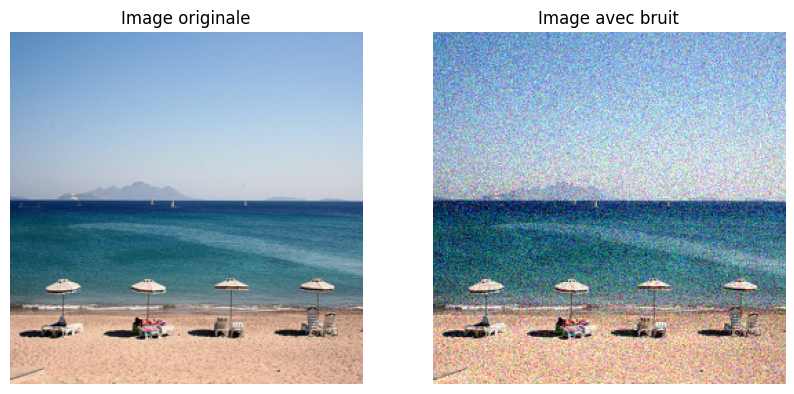

In [9]:
# Fonction pour ajouter du bruit gaussien
def add_gaussian_noise(images, mean=0.0, std=0.1):
    noisy_images = []
    for img in images:
        noise = np.random.normal(mean, std, img.shape)
        noisy_img = np.clip(img + noise, 0, 1)  # Clipper entre 0 et 1
        noisy_images.append(noisy_img)
    return np.array(noisy_images)
# Ajout de bruit gaussien aux images
X_noisy = add_gaussian_noise(X, mean=0.0, std=0.1)
# Affichage d'une image originale et de son bruit
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(X[0])
plt.title("Image originale")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(X_noisy[0])
plt.title("Image avec bruit")
plt.axis("off")
plt.show()

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.optimizers import Adam

input_img = Input(shape=(img_size, img_size, 3))

# Encodeur
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)    # 256x256x32
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)            # 256x256x64
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)            # 256x256x64

# Bottleneck
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)           # 256x256x128
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)           # 256x256x128

# Décodeur
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)            # 256x256x64
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)            # 256x256x64
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)            # 256x256x32

# Sortie
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)    # 256x256x3

# Compilation
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=Adam(), loss='mse')

# Résumé
autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 256, 256, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 256, 256, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 256, 256, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 256, 256, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 256, 256, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 186,371 (728.01 KB)

 Trainable params: 186,371 (728.01 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
print("[INFO] Début de l'entraînement du modèle 3 couches...\n")

history = autoencoder.fit(
    X_noisy,
    X,
    epochs=10,
    batch_size=16,
    shuffle=True,
    validation_split=0.1,
    verbose=1  # affichage classique de Keras
)

print("\n[INFO] Entraînement terminé.")
print(f"[INFO] Dernière loss entraînement : {history.history['loss'][-1]:.5f}")
print(f"[INFO] Dernière loss validation   : {history.history['val_loss'][-1]:.5f}")

[INFO] Début de l'entraînement du modèle 3 couches...

Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 403ms/step - loss: 0.0748 - val_loss: 0.0514
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 361ms/step - loss: 0.0480 - val_loss: 0.0145
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 366ms/step - loss: 0.0178 - val_loss: 0.0130
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 367ms/step - loss: 0.0131 - val_loss: 0.0072
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 362ms/step - loss: 0.0081 - val_loss: 0.0079
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 370ms/step - loss: 0.0069 - val_loss: 0.0039
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 362ms/step - loss: 0.0052 - val_loss: 0.0046
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 367ms/step - loss: 0.0049 - val_loss: 0.0033
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 361ms/step - loss: 0.0041 - val_loss: 0.0031
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 361ms/step - loss: 0.0039 - val_loss: 0.0031

[INFO] Entraînement terminé.
[INFO] Dernière loss entraînement : 0.00388
[INFO] Dernière loss validatio

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step


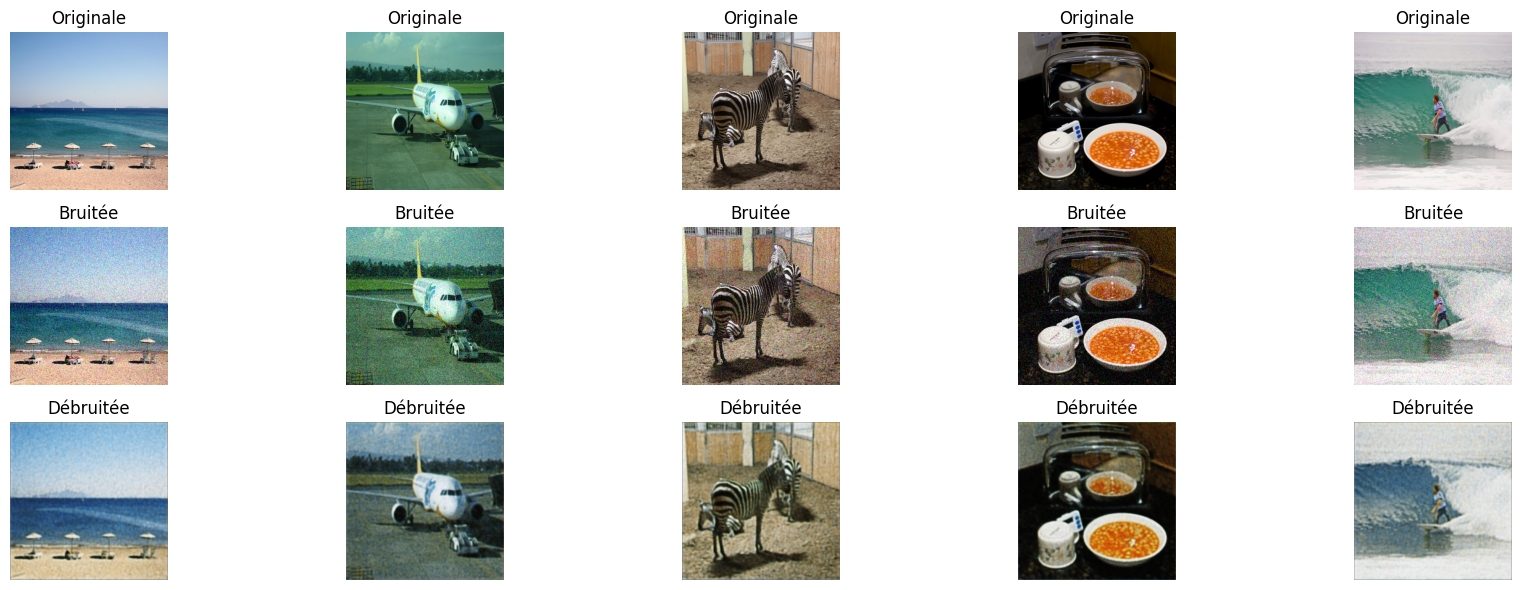

In [12]:
# Prédiction du modèle
decoded_imgs = autoencoder.predict(X_noisy)

# Affichage de quelques exemples
n = 5  # nombre d'exemples à afficher
plt.figure(figsize=(18, 6))

for i in range(n):
    # Image originale
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(X[i])
    plt.title("Originale")
    plt.axis("off")

    # Image bruitée
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(X_noisy[i])
    plt.title("Bruitée")
    plt.axis("off")

    # Image débruitée
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(decoded_imgs[i])
    plt.title("Débruitée")
    plt.axis("off")

plt.tight_layout()
plt.show()